<h2>Applied Regression Analysis: Final Project<br/><br/>
Title:<em>Using the Yield Curve and Yield Spreads to Predict Recessions in the United States</em><br/><br/>
By: Maeve Tsivanidis, Corey Moser & Pavan Surabhi<br/><br/>March 12, 2019
</h2>

<h2>Project Explanation</h2>
<p>The goal of our regression analysis was to determine if a relationship exists between the shape of the government yield curve and recessions. We used yield curve data from Bloomberg going as far back as the 1950s to get the US 2-Year, 5-Year, and 10-Year data.</p> 
<p>A traditional yield curve is upward sloping to reflect higher interest rates for longer maturities. An inverted yield curve is just the opposite: near-dated maturities have higher yields. Both are shown below for reference. Economists traditionally reason that near dated yields reflect liquidity whereas longer dated maturities reflect future growth expectations. In a healthy economy borrowers and lenders have plenty of short-term liquidity and a healthy demand for long term loans.</p> 
<p>To determine If the yield curve was inverted, we calculated the spreads between the different tenors using the yield data. Spreads between the different tenors were appended to our data frame. </p>

In [8]:
from IPython.display import Image

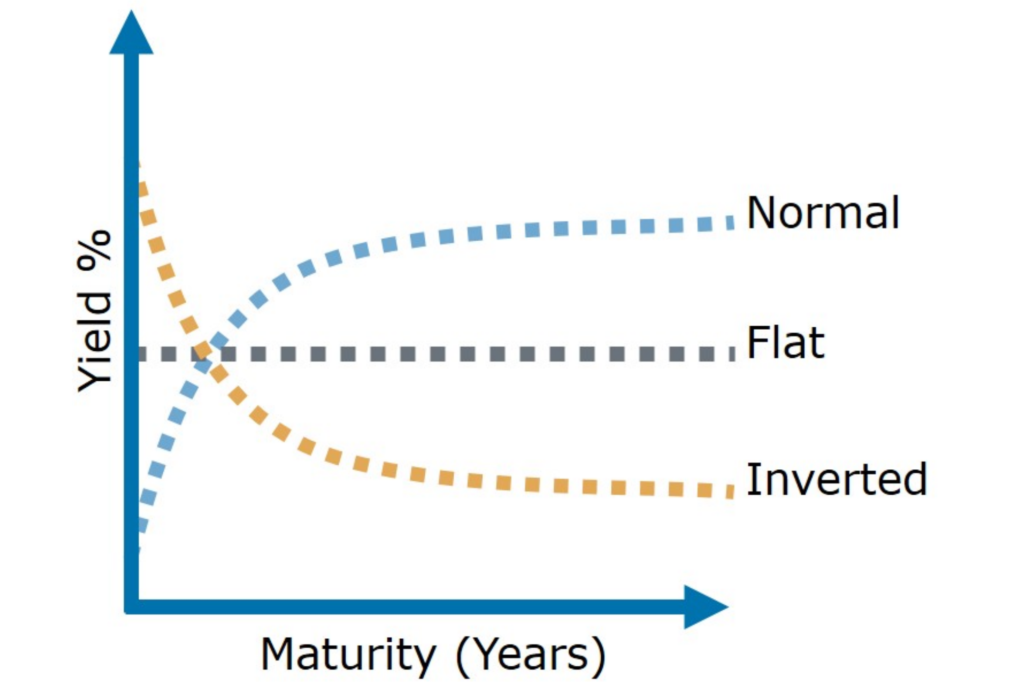

In [9]:
PATH = r"C:\Users\Corey Moser\Documents\Columbia Coursework\+Completed\Semester4\Semester4_Applied_Regression_Analysis\FinalProject"
Image(filename = PATH + "\img1_yield_curves.png", height = 341, width = 512)

<p><b>Source</b>: Creger, Mark. “The Shape of the U.S. Treasury Yield Curve.” COLOTRUST, 26 Sept. 2018,<br/> www.colotrust.com/the-shape-of-the-u-s-treasury-yield-curve/.</p>

<h2>Data Sourcing and Organization</h2>


<p>We  downloaded GDP data from the St. Louis Fed and Bloomberg. We used the academic definition of a recession which is <em>two straight quarters of negative GDP growth</em>. 

<p>After we acquired all the time series we cleaned and structured the data into a python data frame so we could easily  regress different independent variables (yields & spreads) against the GDP data. We created a separate column to identify recessions as a binary 1 or 0. In our 171 quarters worth of data recessions only happened 3.51% of the time. This made finding a good-fit model rather difficult.</p>

<h2>Results Overview</h2>

<p>
We first tried a logistic regression of the yields and spreads against our binary dependent variable. As excepted we didn’t find a whole lot of correlation as this yielded low pseudo R<sup>2</sup> across the board. When we regressed just the spreads to our recession indicator, it was an even lower R<sup>2</sup>.</p>

<p>Since we had very few incidents of recession, we were unable to find a good fit. So we next tried to determine if the yield curve and spreads were correlated with the overall GDP growth rate. There was no clear fit here as well. We did have low p-values but also a low R<sup>2</sup>, which didn't establish a relationship between the yields and GDP growth rate.</p>

<p>We next wanted to introduce a lag to our spreads to see if there was a better correlation to recessions. With a 3-month or 1 quarter lag, our R<sup>2</sup> improved but not enough be statistically significant. We introduced lags of 1 quarters, 3 quarters, 4 quarters, 6 quarters, and 8 quarter, yet our fit did not improve.</p>

<p><b>Below you'll find the results of our analysis as well as data plotting which we hoped might reveal previously unnoticed relationships for us to test</b></p> 

<h2>Import Packages</h2>

In [10]:
import pandas as pd
import numpy as np
import xlwings as xw
import sklearn as skl
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import timedelta

<h2>Load the data</h2>

<b>This data is taken from Bloomberg. It includes quarterly data on:
    <ul>
        <li>10-year treasury</li>
        <li>5-year treasury</li>
        <li>2-year treasury</li>
        <li>U.S. GDP</li>
    </ul>
</b>

In [11]:
path = r'C:\Users\Corey Moser\Documents\Columbia Coursework\+Completed\Semester4\Semester4_Applied_Regression_Analysis\FinalProject'
data = pd.read_excel(path +'/RatesRawDatav2.xlsx')

<h2>Data Preprocessing</h2>

In [12]:
#Look at the top of the data (first 5 rows). A lot of NaNs early on indicate we need to do some cleanup
data.head()

,Dates,10yr_lastprice,10yr_lowprice,2yr_lastprice,2yr_lowprice,5yr_lastprice,5yr_lowprice,overnight_lastprice,overnight_lowprice,gdp
0,1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.9
1,1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
2,1950-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.3
3,1950-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
4,1951-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6


In [13]:
# Drop the overnight_lowprice column -- we don't need it 
data.drop(columns=['overnight_lowprice'], inplace=True)
data.head()

,Dates,10yr_lastprice,10yr_lowprice,2yr_lastprice,2yr_lowprice,5yr_lastprice,5yr_lowprice,overnight_lastprice,gdp
0,1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.9
1,1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
2,1950-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.3
3,1950-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
4,1951-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6


In [14]:
# Create new columns to calc spreads on the rates
data['2y10y'] = data['10yr_lastprice'] - data['2yr_lastprice']
data['2y5y'] = data['5yr_lastprice'] - data['2yr_lastprice']
data['5y10y'] = data['10yr_lastprice'] - data['5yr_lastprice']

In [15]:
data.head()

,Dates,10yr_lastprice,10yr_lowprice,2yr_lastprice,2yr_lowprice,5yr_lastprice,5yr_lowprice,overnight_lastprice,gdp,2y10y,2y5y,5y10y
0,1950-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.9,NaN,NaN,NaN
1,1950-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7,NaN,NaN,NaN
2,1950-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.3,NaN,NaN,NaN
3,1950-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
4,1951-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN


In [16]:
#Change the Dates column to the pandas built in datetime format
data['Dates'] =  pd.to_datetime(data['Dates'], format='%Y-%m-%d')

In [17]:
#Drop all rows where there are NaNs in the three columns included here
data = data.dropna(subset=['2y10y', '2y5y', '5y10y'])

In [18]:
data.columns

Index(['Dates', '10yr_lastprice', '10yr_lowprice', '2yr_lastprice',
       '2yr_lowprice', '5yr_lastprice', '5yr_lowprice', 'overnight_lastprice',
       'gdp', '2y10y', '2y5y', '5y10y'],
      dtype='object')

In [19]:
#redorder columns
data = data[['Dates', '10yr_lastprice', '10yr_lowprice', '5yr_lastprice', '5yr_lowprice', 
             '2yr_lastprice', '2yr_lowprice', '5y10y', '2y10y', '2y5y', 'gdp']]

In [20]:
data.head()

,Dates,10yr_lastprice,10yr_lowprice,5yr_lastprice,5yr_lowprice,2yr_lastprice,2yr_lowprice,5y10y,2y10y,2y5y,gdp
105,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,3.1
106,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,2.1
107,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,3.0
108,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,4.7
109,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,8.1


In [21]:
#Create a new column called "is_recession". A recession is defined as two consecutive quarters of gdp < 0 (negative growth)
data = data.assign(is_recession=np.nan)

In [22]:
data.head()

,Dates,10yr_lastprice,10yr_lowprice,5yr_lastprice,5yr_lowprice,2yr_lastprice,2yr_lowprice,5y10y,2y10y,2y5y,gdp,is_recession
105,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,3.1,NaN
106,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,2.1,NaN
107,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,3.0,NaN
108,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,4.7,NaN
109,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,8.1,NaN


In [23]:
# Create a new column called "gdp_last_quarter" which equals the "gdp" column shifted down by 1 row
data['gdp_last_quarter']=data['gdp'].shift(+1)
data.head()

,Dates,10yr_lastprice,10yr_lowprice,5yr_lastprice,5yr_lowprice,2yr_lastprice,2yr_lowprice,5y10y,2y10y,2y5y,gdp,is_recession,gdp_last_quarter
105,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,3.1,NaN,NaN
106,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,2.1,NaN,3.1
107,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,3.0,NaN,2.1
108,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,4.7,NaN,3.0
109,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,8.1,NaN,4.7


In [24]:
#redorder columns again with our target ("is_recession") as the final column
data = data[['Dates', '10yr_lastprice', '10yr_lowprice', '5yr_lastprice', '5yr_lowprice', 
             '2yr_lastprice', '2yr_lowprice', '5y10y', '2y10y', '2y5y', 'gdp','gdp_last_quarter','is_recession']]

In [25]:
data.head()

,Dates,10yr_lastprice,10yr_lowprice,5yr_lastprice,5yr_lowprice,2yr_lastprice,2yr_lowprice,5y10y,2y10y,2y5y,gdp,gdp_last_quarter,is_recession
105,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,3.1,NaN,NaN
106,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,2.1,3.1,NaN
107,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,3.0,2.1,NaN
108,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,4.7,3.0,NaN
109,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,8.1,4.7,NaN


In [26]:
#Fill in the is_recession column using the custom function below. 
# If gdp and gdp_last_quarter both are less than 0, then is_recession = 1, else = 0
def recession(row):
    if row['gdp'] < 0 and row['gdp_last_quarter'] < 0:
        val = 1
    else:
        val = 0
    return val

In [27]:
#Apply our new function column wise (Axis =1) to the is_recession column
data['is_recession'] = data.apply(recession, axis=1)

In [28]:
#Because we dropped rows earlier we need to reset the index
data.reset_index(drop=True, inplace=True)

In [29]:
#Numbers in the column headers might confused statsmodels. Renaming with letters only
data.rename(columns={'10yr_lastprice':'TenYr_lastprice', '5yr_lastprice':'FiveYr_lastprice', '2yr_lastprice':'TwoYr_lastprice',
                     '5y10y':'FiveYTenY',
                    '2y10y':'TwoYTenY',
                    '2y5y':'TwoYFiveY'}, inplace=True)

In [30]:
data.head()

,Dates,TenYr_lastprice,10yr_lowprice,FiveYr_lastprice,5yr_lowprice,TwoYr_lastprice,2yr_lowprice,FiveYTenY,TwoYTenY,TwoYFiveY,gdp,gdp_last_quarter,is_recession
0,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,3.1,NaN,0
1,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,2.1,3.1,0
2,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,3.0,2.1,0
3,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,4.7,3.0,0
4,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,8.1,4.7,0


In [31]:
# How many times has a recession been signalled as % of total obs?
percent =  np.sum(data['is_recession'])/len(data)
percent_formatted = (str(round(percent,4)*100)+"%")
print(f"Of our {len(data)} quarters worth of data, a recession occured approximately {percent_formatted} of the time ")

Of our 171 quarters worth of data, a recession occured approximately 3.51% of the time 


In [32]:
data[['is_recession','gdp','gdp_last_quarter']]

,is_recession,gdp,gdp_last_quarter
0,0,3.1,NaN
1,0,2.1,3.1
2,0,3.0,2.1
3,0,4.7,3.0
4,0,8.1,4.7
5,0,7.3,8.1
6,0,0.0,7.3
7,0,1.4,0.0
8,0,16.5,1.4
9,0,4.0,16.5


<h2>Regressions</h2>

<h3>Regression #1</h3

<b>Because we're predicting a binary outcome (is recession, yes or no), we start by running a logistic regression with all variables; the 2, 5 and 10-year treasuries and their spreads</b>


In [33]:
# Logistic Regression - All variables included (risk collinearity)
model1 = smf.logit('is_recession ~ TenYr_lastprice + FiveYr_lastprice + TwoYr_lastprice + FiveYTenY + TwoYTenY + TwoYFiveY', 
              data=data).fit()
model1_rsquare = model1.prsquared 
print(model1.summary())

         Current function value: 0.149688
         Iterations: 35


C:\Users\Corey Moser\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Corey Moser\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\Corey Moser\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Corey Moser\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Corey Moser\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                           Logit Regression Results                           
Dep. Variable:           is_recession   No. Observations:                  171
Model:                          Logit   Df Residuals:                      167
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                 0.01524
Time:                        15:03:50   Log-Likelihood:                -25.597
converged:                      False   LL-Null:                       -25.993
                                        LLR p-value:                    0.8513
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.5463      1.653     -2.751      0.006      -7.786      -1.307
TenYr_lastprice      0.2002   3.78e+06   5.29e-08      1.000   -7.41e+06    7.41e+06
FiveYr_lastprice    -0.0459 

<b>Results we're not great. We run another logistic regression just on the spreads themselves.</b>

<h3>Regression #2</h3

In [34]:
# Run regression just on the spreads, not the price
model2 = smf.logit('is_recession ~ FiveYTenY + TwoYTenY + TwoYFiveY', 
              data=data).fit()
model2_rsquare = model2.prsquared
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.151537
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           is_recession   No. Observations:                  171
Model:                          Logit   Df Residuals:                      168
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                0.003082
Time:                        15:03:50   Log-Likelihood:                -25.913
converged:                       True   LL-Null:                       -25.993
                                        LLR p-value:                    0.9230
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4065      0.631     -5.396      0.000      -4.644      -2.169
FiveYTenY     -0.4790    2.9e

<b>Even worse results. Our pseudo R<sup>2</sup> was even lower without actual treasury prices</b><br/><br/>


<h3>Regression #3</h3>


<b>Next, we run a linear regression of the spreads against GDP</b>

In [35]:
model3 = smf.ols('gdp ~ + FiveYTenY + TwoYTenY + TwoYFiveY', 
              data=data).fit()
model3_rsquare = model3.rsquared
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     3.737
Date:                Tue, 19 Mar 2019   Prob (F-statistic):             0.0258
Time:                        15:03:50   Log-Likelihood:                -427.26
No. Observations:                 171   AIC:                             860.5
Df Residuals:                     168   BIC:                             869.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1704      0.328      9.652      0.0

<b>Variables have low p-values (indicating significance) but our model does not explain must of the data. Very low R<sup>2</sup> of 4.3%</b>

<b>New Strategy: Create lagged variables of the TwoYTenY spread. Because we have quarterly data we can lag in three month increments as shown below</b> 

In [36]:
# Regression results above are very poor, now we investigate lagged variables for 2y10y

data['TwoYTenY_3m_lag'] = data['TwoYTenY'].shift(+1)
data['TwoYTenY_6m_lag'] = data['TwoYTenY'].shift(+2)
data['TwoYTenY_9m_lag'] = data['TwoYTenY'].shift(+3)
data['TwoYTenY_12m_lag'] = data['TwoYTenY'].shift(+4)
data['TwoYTenY_15m_lag'] = data['TwoYTenY'].shift(+5)
data['TwoYTenY_18m_lag'] = data['TwoYTenY'].shift(+6)
data['TwoYTenY_21m_lag'] = data['TwoYTenY'].shift(+7)
data['TwoYTenY_24m_lag'] = data['TwoYTenY'].shift(+8)

data[['TwoYTenY','TwoYTenY_3m_lag','TwoYTenY_6m_lag']]


,TwoYTenY,TwoYTenY_3m_lag,TwoYTenY_6m_lag
0,0.8420,NaN,NaN
1,1.2220,0.8420,NaN
2,1.4720,1.2220,0.8420
3,1.4030,1.4720,1.2220
4,1.1130,1.4030,1.4720
5,0.5830,1.1130,1.4030
6,0.5330,0.5830,1.1130
7,0.4430,0.5330,0.5830
8,0.1330,0.4430,0.5330
9,-0.1470,0.1330,0.4430


<h3>Regression #4</h3

In [37]:
# Run linear regression with lagged variables
model4= smf.ols('gdp ~ TwoYTenY + TwoYTenY_3m_lag+TwoYTenY_6m_lag+TwoYTenY_12m_lag', 
              data=data).fit()
model4_rsquare = model4.rsquared
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     7.363
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           1.79e-05
Time:                        15:03:50   Log-Likelihood:                -408.69
No. Observations:                 167   AIC:                             827.4
Df Residuals:                     162   BIC:                             843.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.8433      0.332  

<b>Our results are better but the three month lag does not appear significant.</b>

<h3>Regression #5</h3>

<b>Try running regression on different lags, remove non-lagged variables</b>

In [38]:
model5 = smf.ols('gdp ~ TwoYTenY_3m_lag+TwoYTenY_6m_lag+TwoYTenY_12m_lag+TwoYTenY_24m_lag', 
              data=data).fit()

model5_rsquare = model5.rsquared
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2.291
Date:                Tue, 19 Mar 2019   Prob (F-statistic):             0.0620
Time:                        15:03:50   Log-Likelihood:                -406.74
No. Observations:                 163   AIC:                             823.5
Df Residuals:                     158   BIC:                             839.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.4680      0.374  

<b>Results are worse, 3m, 12m and 24m lag are insignficant</b>

<h3>Regression #6</h3>

In [39]:
model6 = smf.ols('gdp ~ + TwoYTenY +TwoYTenY_6m_lag+TwoYTenY_9m_lag+TwoYTenY_18m_lag', 
              data=data).fit()
model6_rsquare = model6.rsquared
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.606
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           0.000301
Time:                        15:03:50   Log-Likelihood:                -405.07
No. Observations:                 165   AIC:                             820.1
Df Residuals:                     160   BIC:                             835.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.7129      0.348  

<b>Slightly better results but the 9m, 18m lag are  insignificant</b>

<h3>Regression #7</h3>

In [40]:
model7 = smf.ols('gdp ~ TwoYTenY + TwoYTenY_6m_lag + TwoYTenY_12m_lag',
              data=data).fit()
model7_rsquare = model7.rsquared
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     9.541
Date:                Tue, 19 Mar 2019   Prob (F-statistic):           7.67e-06
Time:                        15:03:50   Log-Likelihood:                -409.13
No. Observations:                 167   AIC:                             826.3
Df Residuals:                     163   BIC:                             838.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.8460      0.332  

<b>Slightly better still, removed 9m and 18m lag added the 12m lag </b>

<h2>Plotting</h2>

<b>Plot #1: Each model's R<sup>2</sup> or, in the case of logistic regression, Pseudo-R<sup>2</sup> values</b>

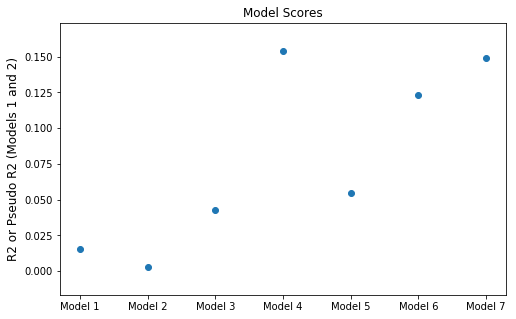

In [41]:
results_dict = {'Model 1': model1_rsquare, 
               'Model 2': model2_rsquare, 
               'Model 3': model3_rsquare, 
               'Model 4': model4_rsquare, 
               'Model 5': model5_rsquare, 
               'Model 6': model6_rsquare,
               'Model 7': model7_rsquare
              }
col_name =  ['model_results']
results_dict_df = pd.DataFrame.from_dict(results_dict, orient='index', columns=col_name)

results_dict_df
fig4= plt.figure(figsize=(8,5))

# plt.xlabel('Model #', fontsize=12)
plt.ylabel('R2 or Pseudo R2 (Models 1 and 2)',fontsize=12)
plt.title('Model Scores',fontsize=12)

plt.scatter(x=results_dict_df.index, y=results_dict_df['model_results'])

<b>Plot #2: Correlation matrix heatmap of all of our indepenedent variables.</b>

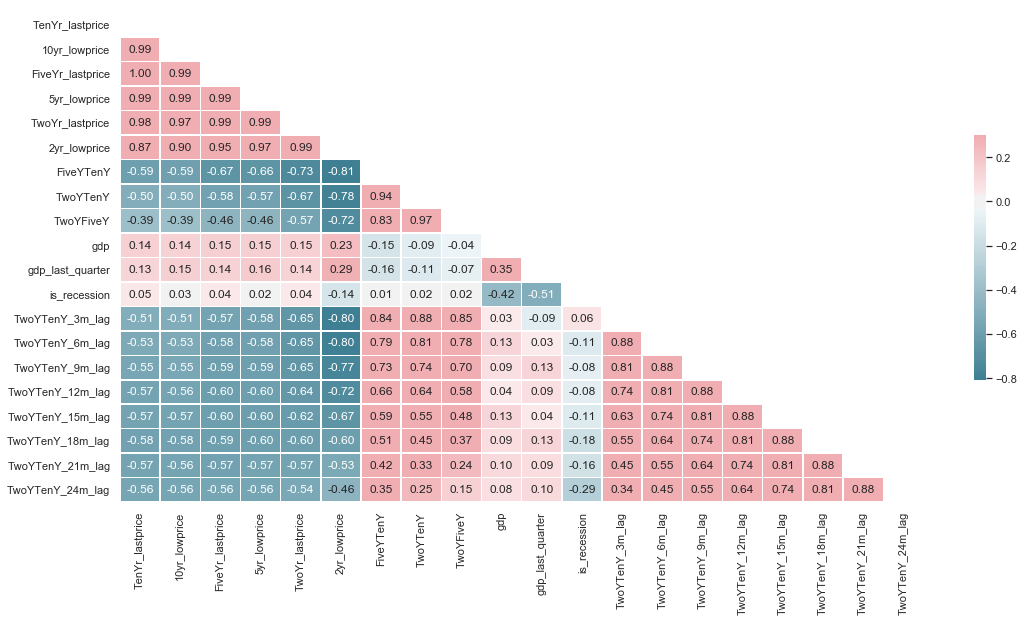

In [42]:
sns.set(style="white")
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, annot=True, fmt=".2f", cbar_kws={"shrink": .5})

<b>Plot #3: US GDP over from 1977 on. Values below the red line indicate negative gdp growth  </b>

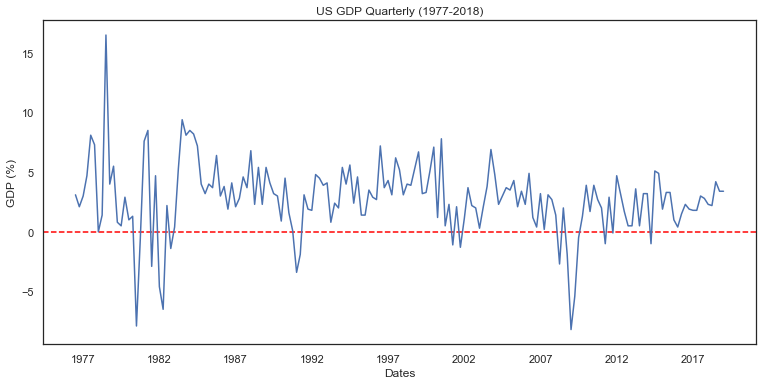

In [43]:
fig= plt.figure(figsize=(11,9))
axes= fig.add_axes([0.1,0.1,0.9,0.5])

x= data['Dates']
y= data['gdp']

plt.axhline(y=0, color='red', linestyle='--')

axes.plot(x,y)
plt.xlabel('Dates')
plt.ylabel('GDP (%)')
plt.title('US GDP Quarterly (1977-2018)')

plt.show()

<b>Plot #4: Treasury prices over time for 10, 5 and 2 year treasuries</b>

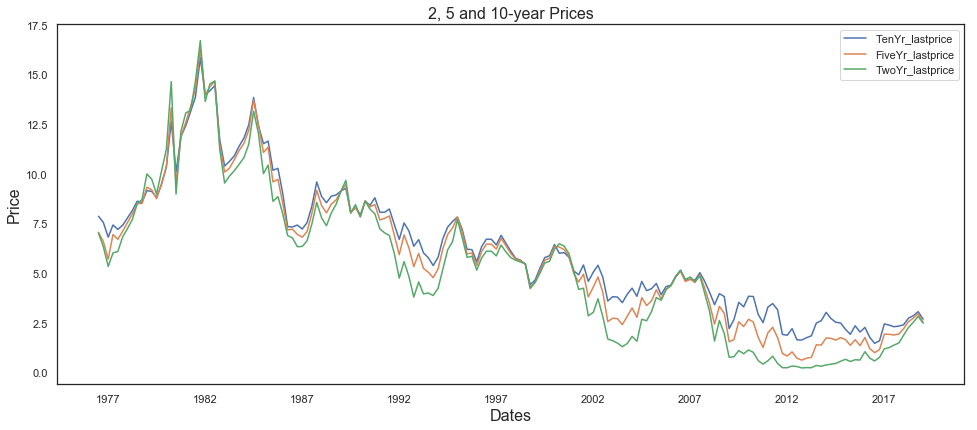

In [44]:
fig2= plt.figure(figsize=(14,10))
axes= fig2.add_axes([0.1,0.1,0.9,0.5])

a= data['Dates']
b= data['TenYr_lastprice']
c= data['FiveYr_lastprice']
d= data['TwoYr_lastprice']

# plt.axhline(y=0, color='red', linestyle='--')

axes.plot(a,b)
axes.plot(a,c)
axes.plot(a,d)

plt.xlabel('Dates', fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('2, 5 and 10-year Prices',fontsize=16)
plt.legend(loc=1)
plt.show()


<b>Plot #5: Spreads over time for 10-5, 10-2 and 5-2</b>

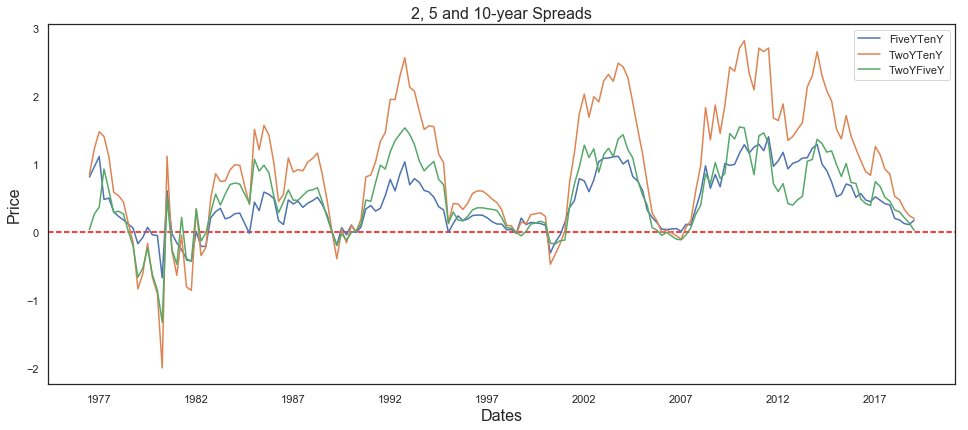

In [45]:
fig2= plt.figure(figsize=(14,10))
axes= fig2.add_axes([0.1,0.1,0.9,0.5])

a= data['Dates']
b= data['FiveYTenY']
c= data['TwoYTenY']
d= data['TwoYFiveY']

plt.axhline(y=0, color='red', linestyle='--')

axes.plot(a,b)
axes.plot(a,c)
axes.plot(a,d)

plt.xlabel('Dates', fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.title('2, 5 and 10-year Spreads',fontsize=16)
plt.legend(loc=1)
plt.show()


<b>Plot #6: Current GDP plotted against previous quarter GDP</b>

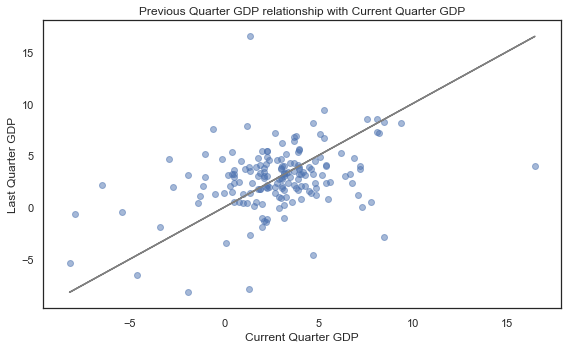

In [46]:
fig3= plt.figure(figsize=(8,8))
axes= fig3.add_axes([0.1,0.1,0.9,0.5])

x = data['gdp_last_quarter']
y = data['gdp']

plt.plot(x,x, color='grey')

plt.xlabel('Current Quarter GDP', fontsize=12)
plt.ylabel('Last Quarter GDP',fontsize=12)
plt.title('Previous Quarter GDP relationship with Current Quarter GDP',fontsize=12)

plt.scatter(x, y, alpha=0.5)

---------------------------------

<b>Plot #7: How many times each spread has inverted (gone negative) </b>

In [47]:
data.head()

,Dates,TenYr_lastprice,10yr_lowprice,FiveYr_lastprice,5yr_lowprice,TwoYr_lastprice,2yr_lowprice,FiveYTenY,TwoYTenY,TwoYFiveY,...,gdp_last_quarter,is_recession,TwoYTenY_3m_lag,TwoYTenY_6m_lag,TwoYTenY_9m_lag,TwoYTenY_12m_lag,TwoYTenY_15m_lag,TwoYTenY_18m_lag,TwoYTenY_21m_lag,TwoYTenY_24m_lag
0,1976-06-30,7.862,7.472,7.054,6.984,7.020,NaN,0.808,0.842,0.034,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1976-09-30,7.552,7.492,6.594,6.514,6.330,NaN,0.958,1.222,0.264,...,3.1,0,0.842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976-12-31,6.812,6.802,5.704,5.594,5.340,NaN,1.108,1.472,0.364,...,2.1,0,1.222,0.842,NaN,NaN,NaN,NaN,NaN,NaN
3,1977-03-31,7.422,6.842,6.944,5.684,6.019,NaN,0.478,1.403,0.925,...,3.0,0,1.472,1.222,0.842,NaN,NaN,NaN,NaN,NaN
4,1977-06-30,7.202,7.162,6.704,6.564,6.089,NaN,0.498,1.113,0.615,...,4.7,0,1.403,1.472,1.222,0.842,NaN,NaN,NaN,NaN


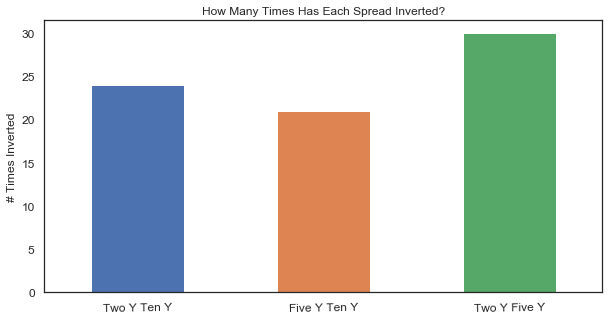

In [48]:
two_y_ten_y_spread = data['TwoYTenY']
two_y_ten_y__count = sum([i < 0 for i in two_y_ten_y_spread])

five_y_ten_y_spread = data['FiveYTenY']
five_y_ten_y_count = sum([i < 0 for i in five_y_ten_y_spread])

two_y_five_y_spread = data['TwoYFiveY']
two_y_five_y_count = sum([i < 0 for i in two_y_five_y_spread])


spreads_dict = {'Two Y Ten Y': two_y_ten_y__count, 
               'Five Y Ten Y': five_y_ten_y_count, 
               'Two Y Five Y': two_y_five_y_count, 
              }
col_name =  ['Counts']

spreads_dict_df = pd.DataFrame.from_dict(spreads_dict, orient='index', columns=col_name)

ax = spreads_dict_df['Counts'].plot(kind='bar', figsize=(10, 5), fontsize=12, rot=1)
ax.set_title("How Many Times Has Each Spread Inverted?", fontsize=12)
ax.set_ylabel("# Times Inverted", fontsize=12)
plt.show()

<h2>Conclusion</h2>

<p>We were unable to find a model that would fit yields or yield spreads to a recession or GDP growth rates. Though we can’t say conclusively there is no correlation between the variables, we have a number of conjectures for why our results did not yield the results we expected</p>
<ul>
    <li> There were only a few instances of recessions going back almost 70 years. The infrequency of recessions makes it very difficult to fit.</li> 
    <li>Also, different times in history have had different absolute rates of interest rates, this was the challenge in trying to model real GDP grow rates over 70 years as a function of government yields.</li> 
</ul>  

<p>Potential solutions to these problems involve using higher frequency data such as monthly or weekly GDP data. Another solution would be to normalize interest rates over different interest rate regimes or use nominal GDP rates instead. We could also incorporate other rates and spreads for investment grade and high yield credit in addition to government interest rates.</p>  
<p>Introducing a lag allowed for a slightly better fit but the big problem was different instances of recessions had different lag times. So, there was no one particular lag time frame that would have generated a good fit. As this graphic from a study by Lazard Asset Management shows (image below) each recession was preceded by an inverted yield curve inversion but the lag itself occured from two to eight quarters prior to the recession itself.</p>


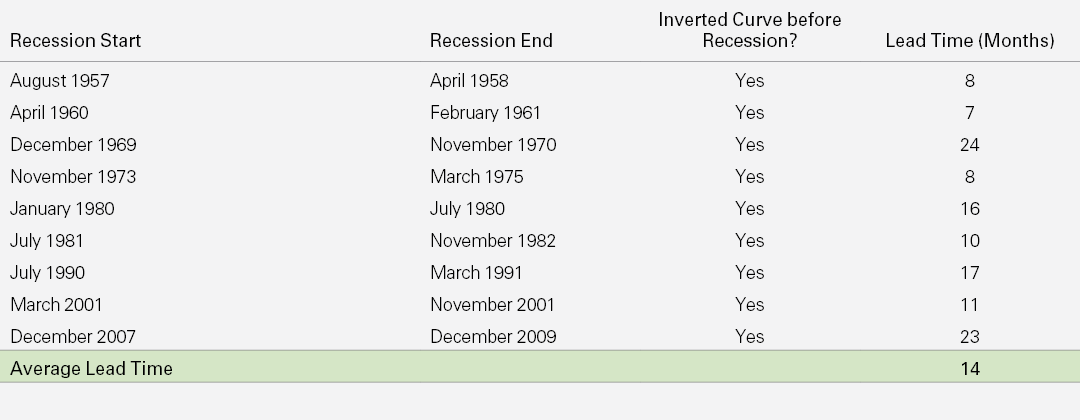

In [58]:
from IPython.display import Image
PATH = (r"C:\Users\Corey Moser\Documents\Columbia Coursework\+Completed\Semester4\Semester4_Applied_Regression_Analysis\FinalProject")
Image(filename = PATH + "\img2_inverted_yield_lead_times.png")

<p><b>Source</b>: Ramos, Eulogio (Joe). “Is the Flattening Yield Curve Signaling a Recession?” Lazard Asset Management, Nov. 2018, www.lazardassetmanagement.com/sg/en_us/research-insights/lazard-insights/is-the-flattening-yield-curve-signaling-a-recession.